In [22]:

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import ylabel
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

F:\Projects\SimpleProj\PandasLearn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('StudentsPerformance.csv')
print(df.head())
print(df.info())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtyp

In [5]:
print(df.iloc[0,0] == 'female')

True


In [3]:
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
numerical_cols = ['math score', 'reading score', 'writing score']

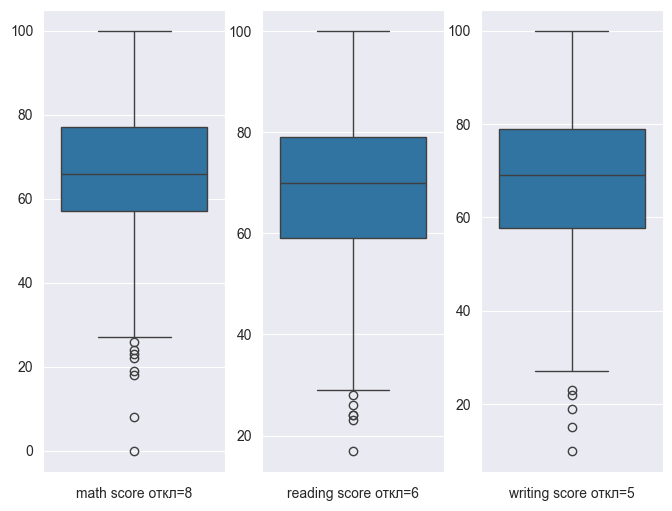

In [4]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(['math score', 'reading score', 'writing score']):
    Q1 = np.quantile(df[col], 0.25)
    Q3 = np.quantile(df[col], 0.75)
    IQR = Q3 - Q1
    lower_outlier_threshold = Q1 - 1.5 * IQR
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], data=df)
    plt.ylabel('')
    plt.xlabel(f'{col} откл={len(df[df[col] < lower_outlier_threshold])}')
plt.show()

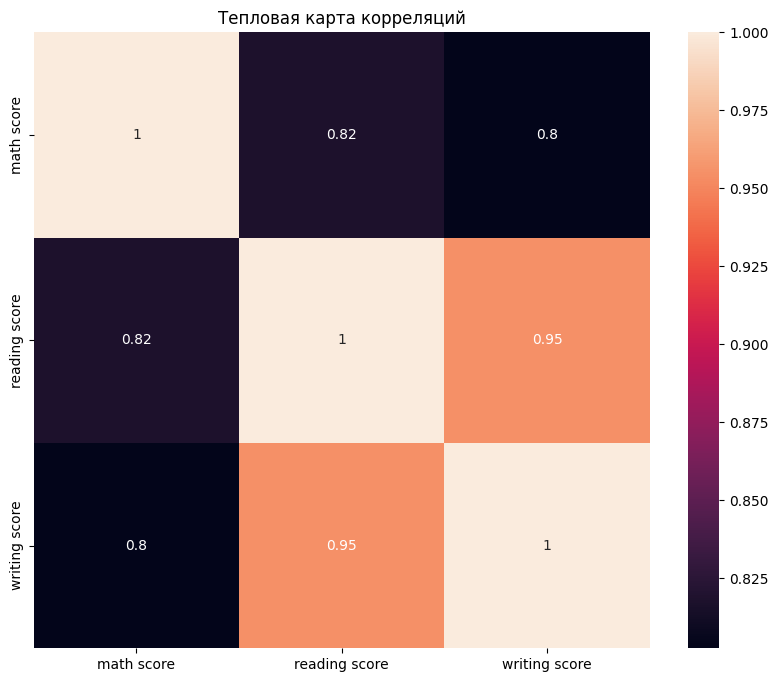

In [32]:
corM = df.loc[:, ['math score', 'reading score', 'writing score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corM, annot=True, square=True)
plt.title('Тепловая карта корреляций')
plt.show()

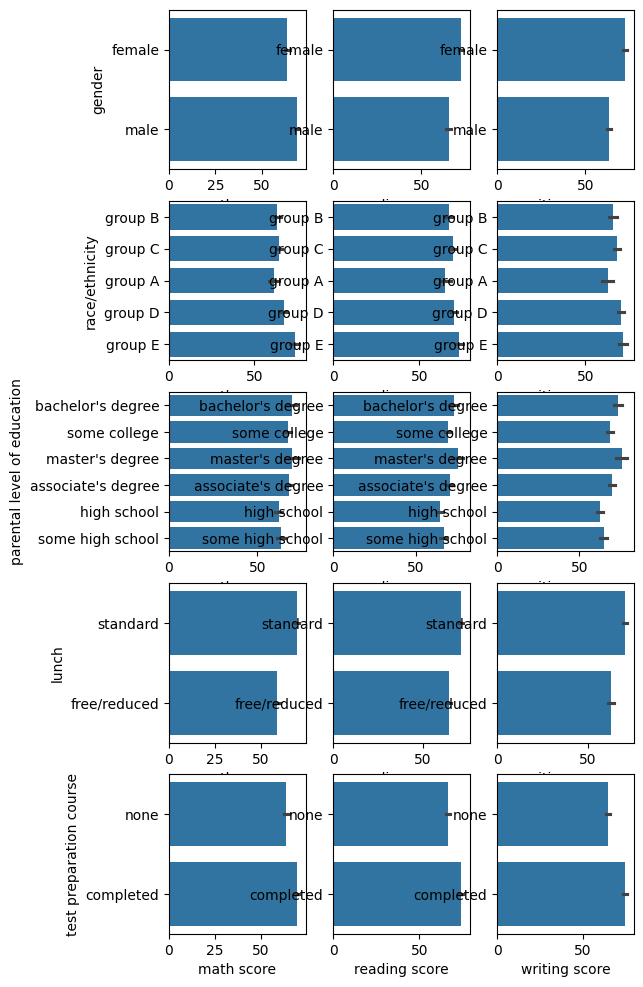

In [47]:
plt.figure(figsize=(6, 12))
for i, col in enumerate(['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']):
    plt.subplot(5, 3, i*3+1)
    sns.barplot(data= df, y= col, x= 'math score')
    plt.subplot(5, 3, i*3+2)
    sns.barplot(data= df, y= col, x= 'reading score')
    plt.ylabel('')
    plt.subplot(5, 3, i*3+3)
    sns.barplot(data= df, y= col, x= 'writing score')
    plt.ylabel('')
plt.show()

In [44]:
def eta_squared(categorical_var, numerical_var):
    """Вычисляет eta-квадрат для категориальной и числовой переменной"""
    categories = categorical_var.unique()
    group_means = []
    group_counts = []
    
    for cat in categories:
        group_data = numerical_var[categorical_var == cat]
        group_means.append(group_data.mean())
        group_counts.append(len(group_data))
    
    overall_mean = numerical_var.mean()
    
    # Вычисляем сумму квадратов между группами (SSB)
    ssb = sum([count * (mean - overall_mean)**2 
               for count, mean in zip(group_counts, group_means)])
    
    # Вычисляем общую сумму квадратов (SST)
    sst = sum((numerical_var - overall_mean)**2)
    
    return ssb / sst if sst != 0 else 0


In [45]:
correlation_matrix = pd.DataFrame(
    index=categorical_cols,
    columns=numerical_cols
)

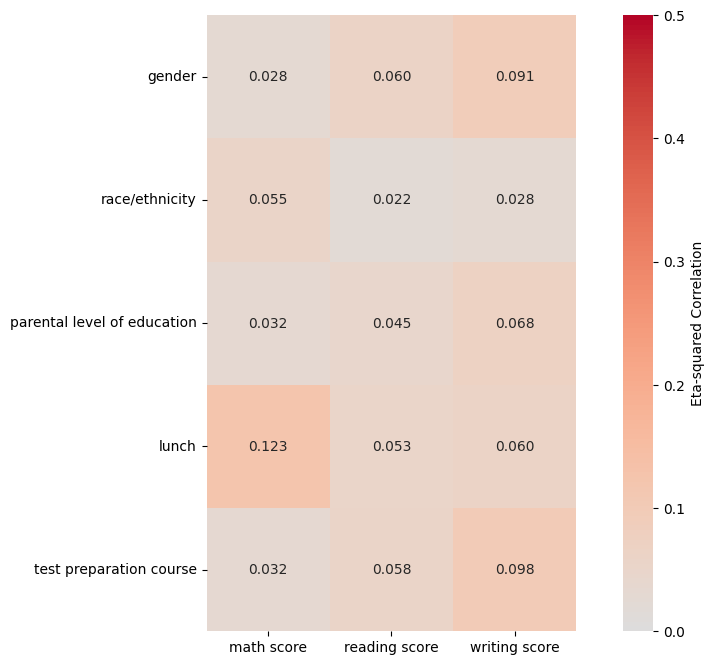

In [52]:
# Заполняем матрицу значениями eta-квадрат
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        correlation_matrix.loc[cat_col, num_col] = eta_squared(df[cat_col], df[num_col])

# Преобразуем в числовой формат
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 8))

# Создаем тепловую карту
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    center=0,
    cmap='coolwarm',
    vmin=0,
    vmax=0.5,
    square=True,
    cbar_kws={'label': 'Eta-squared Correlation'},
    annot_kws={'size': 10}
)

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
scaler = RobustScaler()
scaled_df = df.copy()
scaled_df[numerical_cols] = scaler.fit_transform(scaled_df[numerical_cols])
le = LabelEncoder()

scaled_df['gender'] = le.fit_transform(scaled_df['gender'])
scaled_df['lunch'] = le.fit_transform(scaled_df['lunch'])
scaled_df['test preparation course'] = le.fit_transform(scaled_df['test preparation course'])
scaled_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,group B,bachelor's degree,1,1,0.30,0.10,0.235294
1,0,group C,some college,1,0,0.15,1.00,0.894118
2,0,group B,master's degree,1,1,1.20,1.25,1.129412
3,1,group A,associate's degree,0,1,-0.95,-0.65,-1.176471
4,1,group C,some college,1,1,0.50,0.40,0.282353


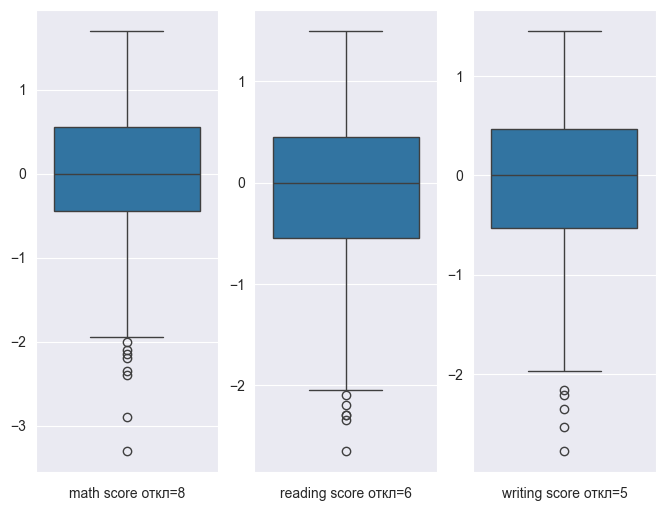

In [9]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(['math score', 'reading score', 'writing score']):
    Q1 = np.quantile(scaled_df[col], 0.25)
    Q3 = np.quantile(scaled_df[col], 0.75)
    IQR = Q3 - Q1
    lower_outlier_threshold = Q1 - 1.5 * IQR
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=scaled_df[col], data=scaled_df)
    plt.ylabel('')
    plt.xlabel(f'{col} откл={len(scaled_df[scaled_df[col] < lower_outlier_threshold])}')
plt.show()

In [39]:
df_Q1_scaled = df.copy()
for i, col in enumerate(['math score', 'reading score', 'writing score']):
    Q1 = np.quantile(scaled_df[col], 0.25)
    Q3 = np.quantile(scaled_df[col], 0.75)
    IQR = Q3 - Q1
    lower_outlier_threshold = Q1 - 1.5 * IQR
    df_Q1_scaled[col] = df_Q1_scaled[col].apply(lambda x: x if x < lower_outlier_threshold else x)

In [5]:
from sklearn.model_selection import train_test_split

X = scaled_df[['gender', 'lunch', 'test preparation course', 'reading score', 'writing score']]
y = scaled_df['math score']
X.head()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

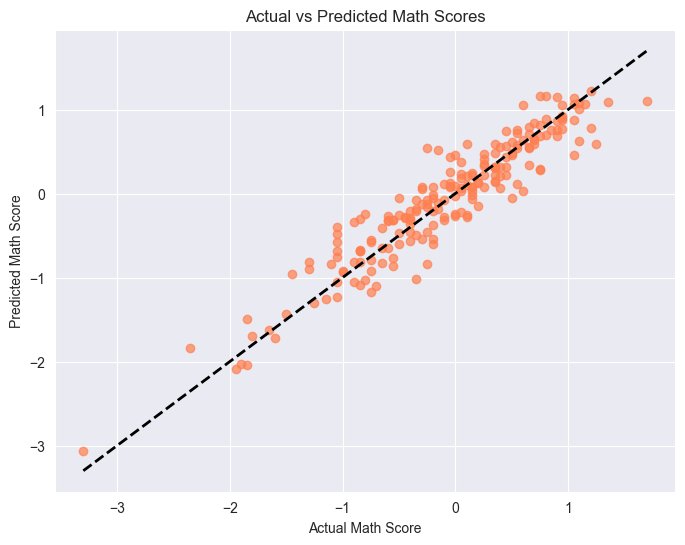

In [8]:
from sklearn.linear_model import LinearRegression

# Fit a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_tr = model.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
metrics = ['RMSE', 'R²', 'MAE', 'MAPE (%)']
scors = pd.DataFrame(data={
    'RMSE': [np.sqrt(mean_squared_error(y_pred_tr, y_train)), np.sqrt(mean_absolute_error(y_pred, y_test))],
    'R²': [r2_score(y_pred_tr, y_train), mean_absolute_percentage_error(y_pred, y_test)],
    'MAE': [mean_absolute_error(y_pred_tr, y_train), mean_absolute_percentage_error(y_pred, y_test)],
    'MAPE (%)': [mean_absolute_percentage_error(y_pred_tr, y_train),mean_absolute_percentage_error(y_pred, y_test)]},
    index=['Train', 'Test'])
print("Метрики качества модели:")
print(scors)

Метрики качества модели:
           RMSE        R²       MAE  MAPE (%)
Train  0.283783  0.833295  0.227598  2.522526
Test   0.457845  0.945448  0.945448  0.945448


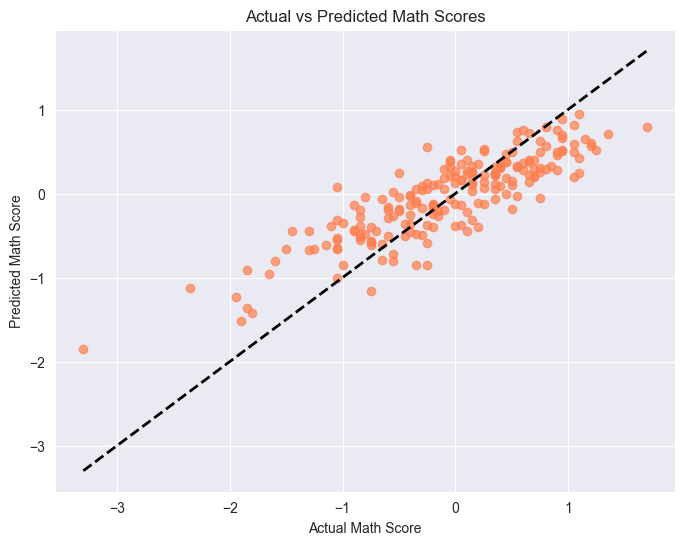

In [10]:
linerRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }
from sklearn import linear_model
l1 = linear_model.Lasso(alpha=0.1)
l1.fit(X_train, y_train)

y_pred = l1.predict(X_test)
y_pred_tr = l1.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
lassoRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

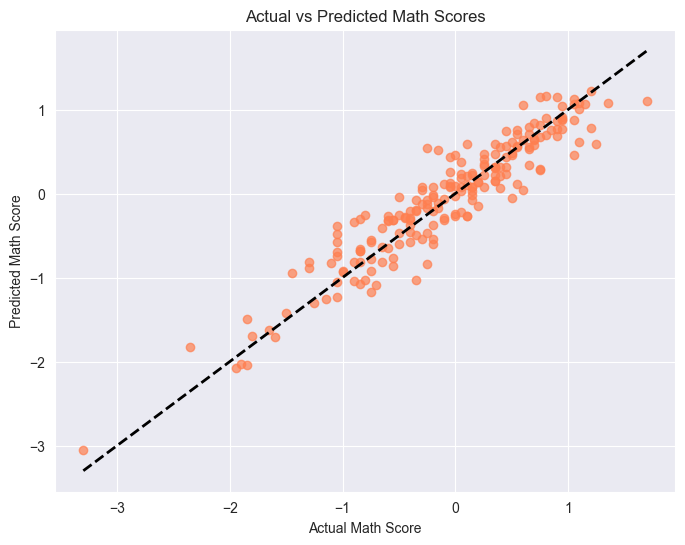

In [17]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
y_pred_tr = ridge.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
ridgeRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

In [20]:
print ('Результаты:')
print(f'Ridge:\n'
      f'\tRMSE: {ridgeRes["RMSE"]}\n'
      f'\tR²: {ridgeRes['R²']}\n'
      f'\tMAE: {ridgeRes["MAE"]}\n'
      f'\tMAPE (%): {ridgeRes["MAPE (%)"]}')
print(f'LASSO:\n'
      f'\tRMSE: {lassoRes["RMSE"]}\n'
      f'\tR²: {lassoRes['R²']}\n'
      f'\tMAE: {lassoRes["MAE"]}\n'
      f'\tMAPE (%): {lassoRes["MAPE (%)"]}')

Результаты:
Ridge:
	RMSE: 0.45788716953592157
	R²: 0.9668617393633749
	MAE: 0.9668617393633749
	MAPE (%): 0.9668617393633749
LASSO:
	RMSE: 0.5931571407203813
	R²: 2.6406885419853983
	MAE: 2.6406885419853983
	MAPE (%): 2.6406885419853983


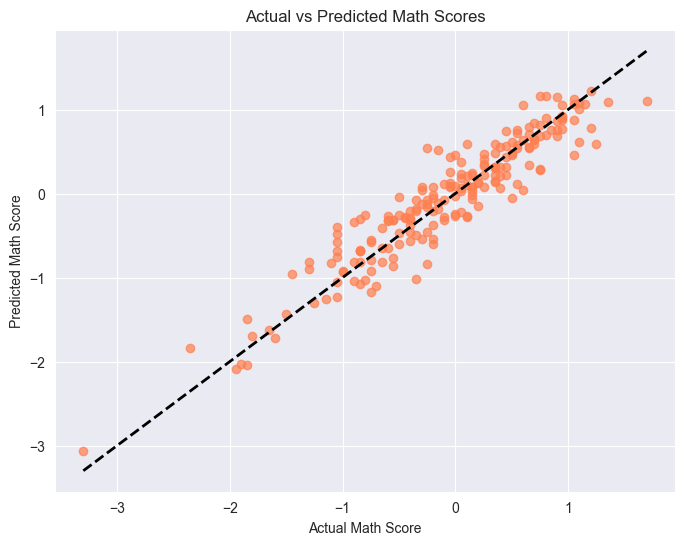

In [43]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [0,0.2,0.5,0.7,1,1.5,2], 'fit_intercept': [True, False]}
parameters = {'alpha': [0.1, 0.2,0.5,0.7,1,1.5,2], 'fit_intercept': [True, False], 'max_iter': [1000,2000,2500]}
grid = GridSearchCV(ridge, parameters, scoring= 'r2')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

ridgeGridRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

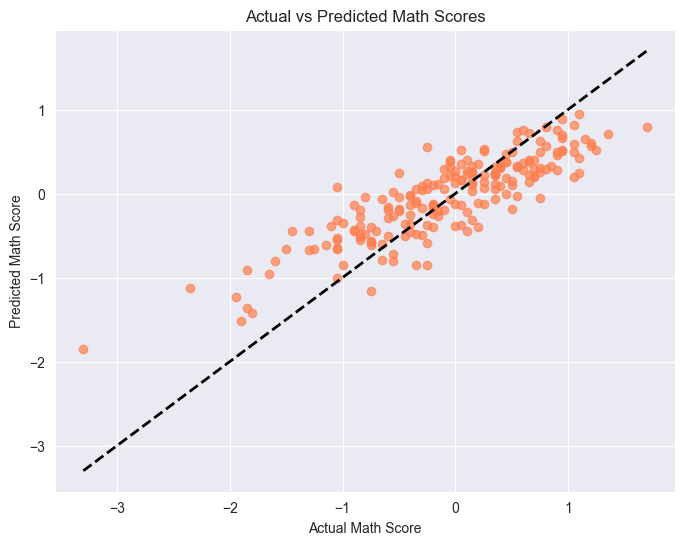

In [44]:
parameters = {'alpha': [0.1, 0.2,0.5,0.7,1,1.5,2], 'fit_intercept': [True, False], 'max_iter': [1000,2000,2500]}
grid = GridSearchCV(l1, parameters, scoring= 'r2')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
losGridRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

In [45]:
print ('Результаты:')
print(f'Ridge:\n'
      f'\tRMSE: {ridgeGridRes["RMSE"]}/ dif is {ridgeRes["RMSE"]-ridgeGridRes["RMSE"]}\n'
      f'\tR²: {ridgeGridRes['R²']}/ dif is {ridgeRes['R²']-ridgeGridRes['R²']}\n'
      f'\tMAE: {ridgeGridRes["MAE"]}/ dif is {ridgeRes["MAE"]-ridgeGridRes["MAE"]}\n'
      f'\tMAPE (%): {ridgeGridRes["MAPE (%)"]}/ dif is {ridgeRes["MAPE (%)"]-ridgeGridRes["MAPE (%)"]}')
print(f'LOSS:\n'
      f'\tRMSE: {losGridRes["RMSE"]}/ dif is {lassoRes["RMSE"]-losGridRes["RMSE"]}\n'
      f'\tR²: {losGridRes['R²']}/ dif is {lassoRes['R²']-losGridRes['R²']}\n'
      f'\tMAE: {losGridRes["MAE"]}/ dif is {lassoRes["MAE"]-losGridRes["MAE"]}\n'
      f'\tMAPE (%): {losGridRes["MAPE (%)"]}/ dif is {lassoRes["MAPE (%)"]-losGridRes["MAPE (%)"]}')

Результаты:
Ridge:
	RMSE: 0.45784994819522623/ dif is 3.7221340695337e-05
	R²: 0.9491152465360227/ dif is 0.01774649282735219
	MAE: 0.9491152465360227/ dif is 0.01774649282735219
	MAPE (%): 0.9491152465360227/ dif is 0.01774649282735219
LOSS:
	RMSE: 0.5931571407203813/ dif is 0.0
	R²: 2.6406885419853983/ dif is 0.0
	MAE: 2.6406885419853983/ dif is 0.0
	MAPE (%): 2.6406885419853983/ dif is 0.0


In [11]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
parameters = {'max_depth': [3,4,5,6], 'n_estimators': [50,100,200,300,500]}
grid = GridSearchCV(RFR, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

NameError: name 'GridSearchCV' is not defined

In [54]:
RFRGridRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

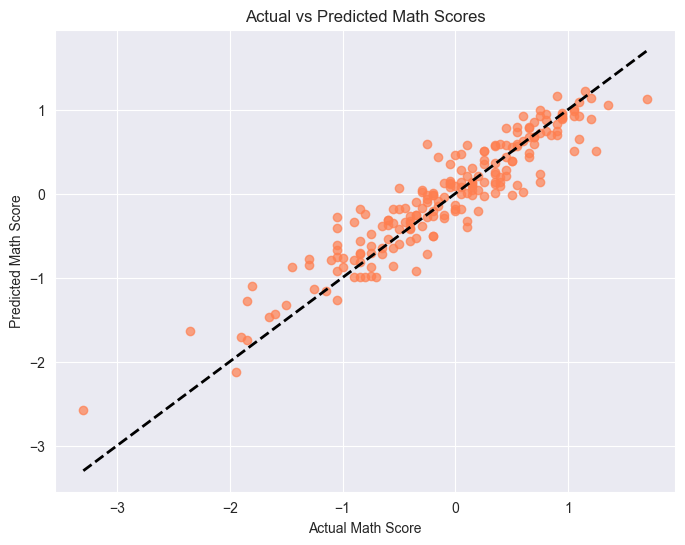

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
parameters = {'max_depth': [3,4,5,6], 'n_estimators': [50,100,200,300,500], 'learning_rate': [0.01,0.1,0.2,0.3,0.5]}
grid = GridSearchCV(GBR, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

# A scatter plot to visualize the actual vs predicted math scores
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
GBRGridRes = {'RMSE': np.sqrt(mean_absolute_error(y_pred, y_test)), 'R²': mean_absolute_percentage_error(y_pred, y_test), 'MAE': mean_absolute_percentage_error(y_pred, y_test), 'MAPE (%)': mean_absolute_percentage_error(y_pred, y_test) }

In [56]:
print ('Результаты:')
print(f'Ridge:\n'
      f'\tRMSE: {RFRGridRes["RMSE"]}\n'
      f'\tR²: {RFRGridRes['R²']}\n'
      f'\tMAE: {RFRGridRes["MAE"]}\n'
      f'\tMAPE (%): {RFRGridRes["MAPE (%)"]}')
print(f'Ridge:\n'
      f'\tRMSE: {GBRGridRes["RMSE"]}\n'
      f'\tR²: {GBRGridRes['R²']}\n'
      f'\tMAE: {GBRGridRes["MAE"]}\n'
      f'\tMAPE (%): {GBRGridRes["MAPE (%)"]}')

Результаты:
Ridge:
	RMSE: 0.4757513116942362
	R²: 20.23461306187599
	MAE: 20.23461306187599
	MAPE (%): 20.23461306187599
Ridge:
	RMSE: 0.46824928938755295
	R²: 3.594256362577192
	MAE: 3.594256362577192
	MAPE (%): 3.594256362577192


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
scaled_df = df.copy()


scaler = RobustScaler()
scaled_df[numerical_cols] = scaler.fit_transform(scaled_df[numerical_cols])
le = LabelEncoder()

scaled_df['gender'] = le.fit_transform(scaled_df['gender'])
scaled_df['lunch'] = le.fit_transform(scaled_df['lunch'])
scaled_df['test preparation course'] = le.fit_transform(scaled_df['test preparation course'])
scaled_df.head()

# replaseDic = {'group A': [1,0,0,0,0], 'group B': [0,1,0,0,0], 'group C': [0,0,1,0,0], 'group D': [0,0,0,1,0], 'group E': [0,0,0,0,1]}
# scaled_df['race/ethnicity'] = scaled_df['race/ethnicity'].apply(lambda x: replaseDic[x])
# 
# val = scaled_df['parental level of education'].unique()
# replaseDic = {}
# for i, col in enumerate(val):
#     arr = np.zeros(len(val))
#     arr[i] = 1
#     arr = arr.astype(int)
#     replaseDic.update({col: arr})
# scaled_df['parental level of education'] = scaled_df['parental level of education'].apply(lambda x: replaseDic[x])    

# replaseDic = {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4}
# scaled_df['race/ethnicity'] = scaled_df['race/ethnicity'].apply(lambda x: replaseDic[x])
# replaseDic = {"bachelor's degree": 4, 'some college': 2, "master's degree": 5, "associate's degree": 3,  'high school': 1, 'some high school': 0}
# scaled_df['parental level of education'] = scaled_df['parental level of education'].apply(lambda x: replaseDic[x])

encoder = OneHotEncoder().fit(scaled_df.loc[:,['race/ethnicity']])
X_categorical_encoded = encoder.transform(scaled_df[['race/ethnicity']]).toarray()
print(type(encoder.categories_))
print(encoder.categories_[0])
print(X_categorical_encoded)
for i, col in enumerate(X_categorical_encoded):
    X_categorical_encoded[i] = X_categorical_encoded[i].astype(int)
X_categorical_encoded = pd.DataFrame(data= X_categorical_encoded, columns=encoder.categories_[0])
print(X_categorical_encoded)
scaled_df = pd.merge(scaled_df, X_categorical_encoded, how='left',left_index=True, right_index=True)
scaled_df = scaled_df.drop(['race/ethnicity'], axis=1)

encoder = OneHotEncoder().fit(scaled_df.loc[:,['parental level of education']])
X_categorical_encoded = encoder.transform(scaled_df[['parental level of education']]).toarray()
for i, col in enumerate(X_categorical_encoded):
    X_categorical_encoded[i] = X_categorical_encoded[i].astype(int)
X_categorical_encoded = pd.DataFrame(data= X_categorical_encoded, columns=encoder.categories_[0])
scaled_df = pd.merge(scaled_df, X_categorical_encoded, how='left',left_index=True, right_index=True)
scaled_df = scaled_df.drop(['parental level of education'], axis=1)

scaled_df.head()


<class 'list'>
['group A' 'group B' 'group C' 'group D' 'group E']
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
     group A  group B  group C  group D  group E
0        0.0      1.0      0.0      0.0      0.0
1        0.0      0.0      1.0      0.0      0.0
2        0.0      1.0      0.0      0.0      0.0
3        1.0      0.0      0.0      0.0      0.0
4        0.0      0.0      1.0      0.0      0.0
..       ...      ...      ...      ...      ...
995      0.0      0.0      0.0      0.0      1.0
996      0.0      0.0      1.0      0.0      0.0
997      0.0      0.0      1.0      0.0      0.0
998      0.0      0.0      0.0      1.0      0.0
999      0.0      0.0      0.0      1.0      0.0

[1000 rows x 5 columns]


,gender,lunch,test preparation course,math score,reading score,writing score,group A,group B,group C,group D,group E,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
0,0,1,1,0.30,0.10,0.235294,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,1,0,0.15,1.00,0.894118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,1,1.20,1.25,1.129412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,1,-0.95,-0.65,-1.176471,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,0.50,0.40,0.282353,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
from sklearn.model_selection import train_test_split

x_col = scaled_df.columns.tolist()
x_col.remove('lunch')
X = scaled_df[x_col]
y = scaled_df['lunch']
X.head()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

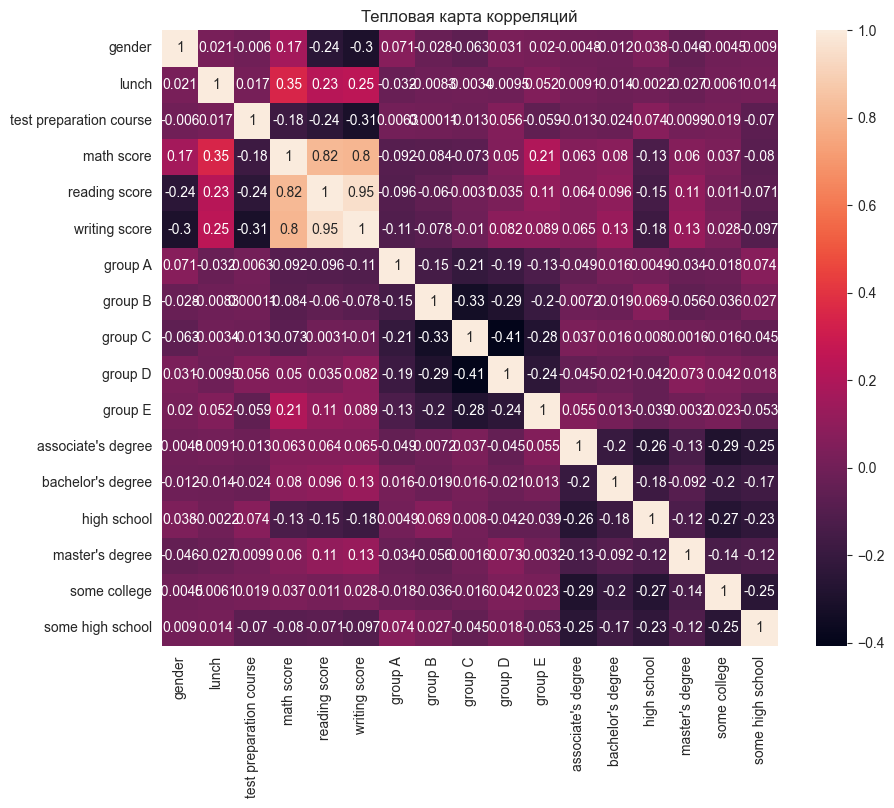

In [8]:
corM = scaled_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corM, annot=True, square=True)
plt.title('Тепловая карта корреляций')
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RFC = RandomForestClassifier()
parameters = {'n_estimators': [500], 'max_depth': [3,5,7], 'min_samples_split': [2,3,4], 'max_features': ['sqrt', 'log2']}
grid = GridSearchCV(RFC, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)



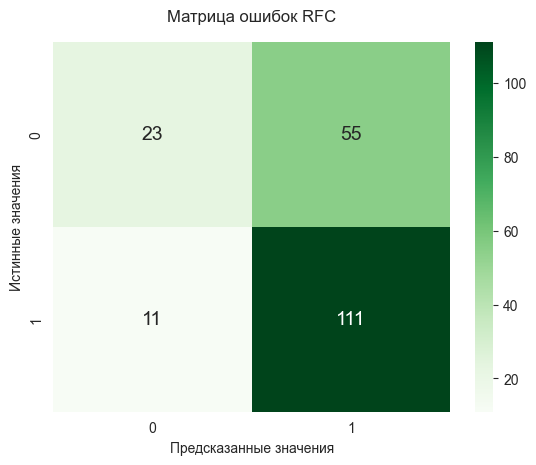

              precision    recall  f1-score   support

    standard       0.68      0.29      0.41        78
free/reduced       0.67      0.91      0.77       122

    accuracy                           0.67       200
   macro avg       0.67      0.60      0.59       200
weighted avg       0.67      0.67      0.63       200

roc_auc_score = 0.6023539302227827


In [21]:

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок RFC', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

parameters = {'priors': [None]}
grid = GridSearchCV(gnb, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

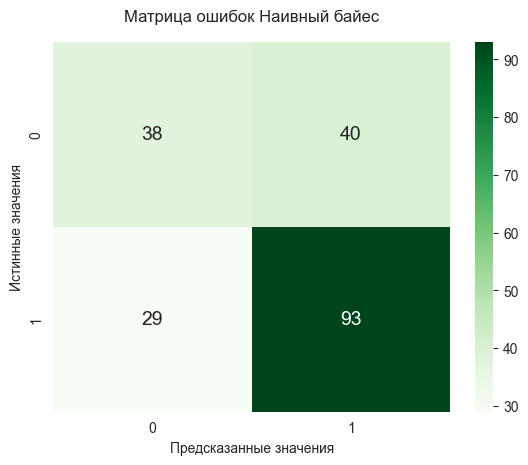

              precision    recall  f1-score   support

    standard       0.57      0.49      0.52        78
free/reduced       0.70      0.76      0.73       122

    accuracy                           0.66       200
   macro avg       0.63      0.62      0.63       200
weighted avg       0.65      0.66      0.65       200

roc_auc_score = 0.6247372845733501


In [24]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок Наивный байес', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

parameters = {'C': [1,3,5,10], 'max_iter': [100,200,300]}
grid = GridSearchCV(lr, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

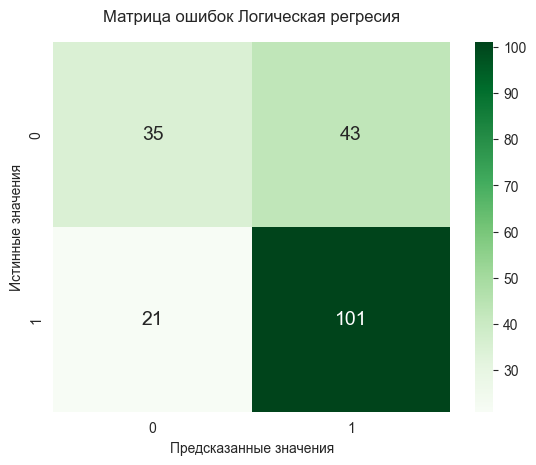

              precision    recall  f1-score   support

    standard       0.62      0.45      0.52        78
free/reduced       0.70      0.83      0.76       122

    accuracy                           0.68       200
   macro avg       0.66      0.64      0.64       200
weighted avg       0.67      0.68      0.67       200

roc_auc_score = 0.6382934005884825


In [27]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок Логическая регресия', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [28]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
parameters = {'n_neighbors': [3,5,7,8], 'algorithm': ['auto', 'ball_tree', 'kd_tree' ]}
grid = GridSearchCV(knn, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

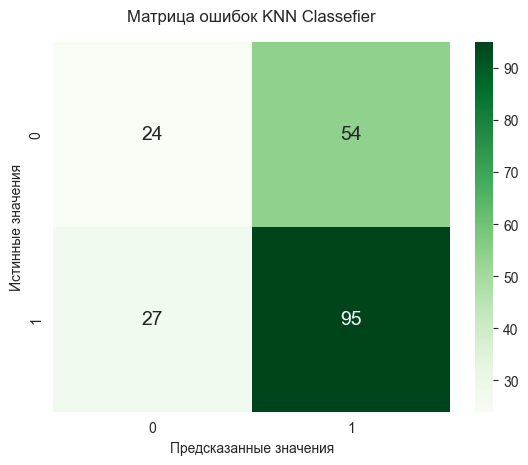

              precision    recall  f1-score   support

    standard       0.47      0.31      0.37        78
free/reduced       0.64      0.78      0.70       122

    accuracy                           0.59       200
   macro avg       0.55      0.54      0.54       200
weighted avg       0.57      0.59      0.57       200

roc_auc_score = 0.5431904161412359


In [29]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок KNN Classefier', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [31]:
from sklearn.svm import SVC
svc = SVC()
parameters = {
    'C': [1,2,3,4]
    # ,'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed' ]
              }
grid = GridSearchCV(svc, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

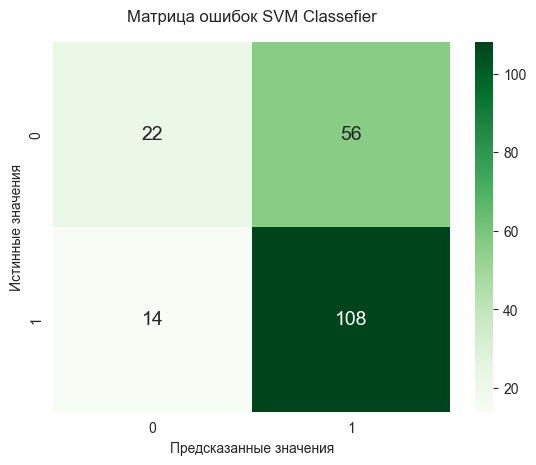

              precision    recall  f1-score   support

    standard       0.61      0.28      0.39        78
free/reduced       0.66      0.89      0.76       122

    accuracy                           0.65       200
   macro avg       0.63      0.58      0.57       200
weighted avg       0.64      0.65      0.61       200

roc_auc_score = 0.5836485918453131


In [32]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок SVM Classefier', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

parameters = {'loss': ['log_loss', 'exponential'], 'learning_rate': [0.05,0.1,0.2], 'max_depth': [3,5,7]}
grid = GridSearchCV(gbc, parameters)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_pred_tr = grid.predict(X_train)

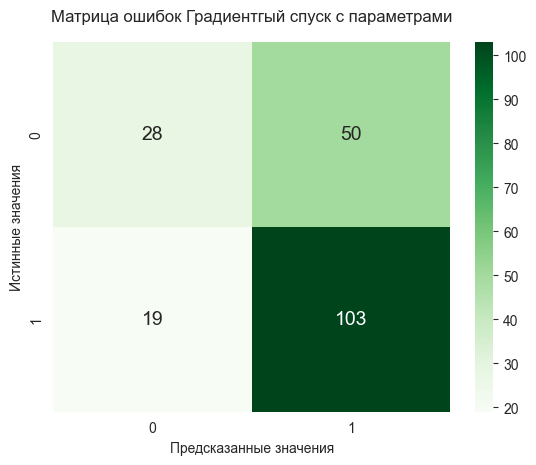

              precision    recall  f1-score   support

    standard       0.60      0.36      0.45        78
free/reduced       0.67      0.84      0.75       122

    accuracy                           0.66       200
   macro avg       0.63      0.60      0.60       200
weighted avg       0.64      0.66      0.63       200

roc_auc_score = 0.6016183270281631


In [18]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок Градиентгый спуск с параметрами', pad=15)
plt.show()

report = classification_report(y_test, y_pred, target_names= ['standard', 'free/reduced'])
print(report)
print(f'roc_auc_score = {roc_auc_score(y_test, y_pred)}')

In [45]:
print(scaled_df.columns)

Index(['gender', 'lunch', 'test preparation course', 'math score',
       'reading score', 'writing score', 'group A', 'group B', 'group C',
       'group D', 'group E', 'associate's degree', 'bachelor's degree',
       'high school', 'master's degree', 'some college', 'some high school'],
      dtype='object')


In [119]:
new_scaled_df = scaled_df.copy()
new_scaled_df = new_scaled_df.loc[:, ['math score', 'reading score', 'writing score','lunch','group E', "master's degree" ]]
X_processed = new_scaled_df


Данные после PCA (2 компоненты):
 [[ 0.44870939  0.28708034]
 [ 1.25290988 -0.11674171]
 [ 2.15264365 -0.02343183]
 ...
 [-0.32450034 -0.67131865]
 [ 0.58647287  0.13261558]
 [ 1.18165519 -0.85042011]]


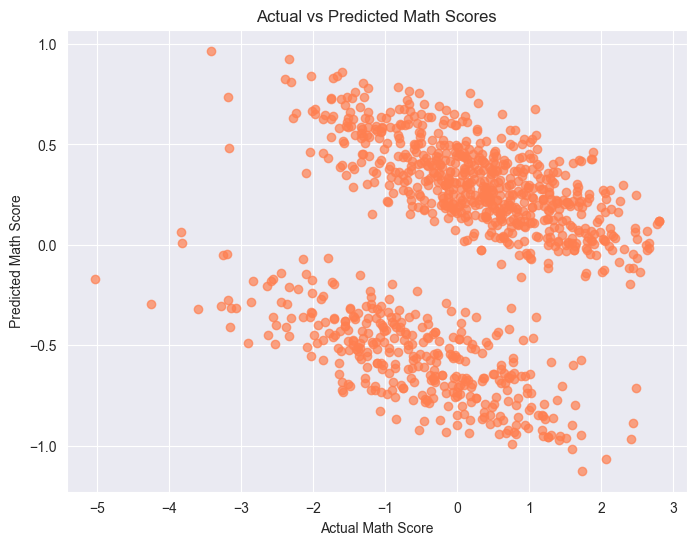

C:\Users\fstru\AppData\Local\Temp\ipykernel_31372\402004904.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', data=pca_df, palette='viridis', legend='full', s=100, alpha=0.7)


<Axes: xlabel='PC1', ylabel='PC2'>

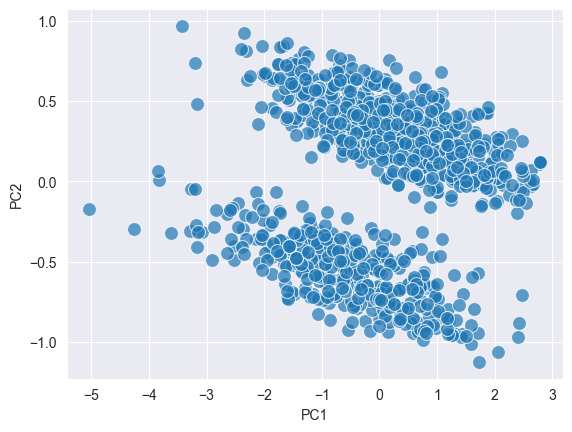

In [120]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(new_scaled_df)
print("\nДанные после PCA (2 компоненты):\n", X_pca)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, color='coral')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.show()

sns.scatterplot(x='PC1', y='PC2', data=pca_df, palette='viridis', legend='full', s=100, alpha=0.7)

In [64]:
print(new_scaled_df.iloc[0].tolist())

[0.3, 0.1, 0.23529411764705882, 1.0, 0.0, 0.0]


[1.4690633959069879, 1.0034744123502408, 0.806889223336604, 0.7556498804567047, 0.9281772981122158, 0.6222557706932287, 0.6232699954701889, 0.6864464996339518, 0.6585637213875035, 0.6363348752488157]


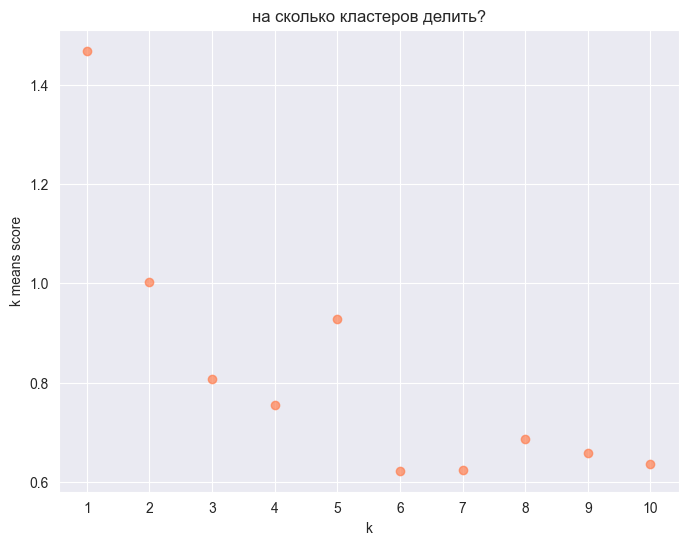

In [43]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math
res = []
frame = new_scaled_df
for i in range(10):
    grid = KMeans(n_clusters=i+1, random_state=42)
    fit = grid.fit(frame)
    lable = fit.labels_
    mns = {}
    for j, col in enumerate(lable):
        if col in mns.keys():
            mns[col] = math.dist(fit.cluster_centers_[col], frame.iloc[j].tolist())  
        else:
            mns.update({col: fit.cluster_centers_[col]})
    lst = list(mns.values())
    # print(mns.values())
    res.append(sum(lst) / len(lst))
print(res)
plt.figure(figsize=(8, 6))
for i, col in enumerate(res):
    plt.scatter(i+1, col, alpha=0.7, color='coral')
plt.xlabel('k')
plt.ylabel('k means score')
plt.title('на сколько кластеров делить?')
plt.xticks(list(range(1,11)))
    
plt.show()
    

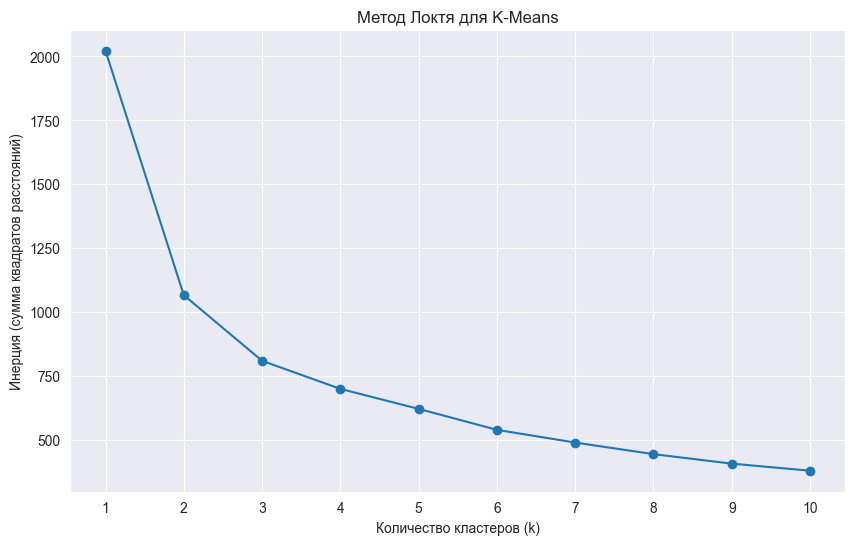

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11) # Пробуем от 1 до 10 кластеров

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init=10 для более стабильных результатов
    kmeans.fit(new_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (сумма квадратов расстояний)')
plt.title('Метод Локтя для K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

K-Means: k=2, Silhouette Score = 0.380
GMM: k=2, Silhouette Score = 0.169
K-Means: k=3, Silhouette Score = 0.290
GMM: k=3, Silhouette Score = 0.179
K-Means: k=4, Silhouette Score = 0.298
GMM: k=4, Silhouette Score = 0.140
K-Means: k=5, Silhouette Score = 0.286
GMM: k=5, Silhouette Score = 0.165
K-Means: k=6, Silhouette Score = 0.297
GMM: k=6, Silhouette Score = 0.176
K-Means: k=7, Silhouette Score = 0.313
GMM: k=7, Silhouette Score = 0.146
K-Means: k=8, Silhouette Score = 0.295
GMM: k=8, Silhouette Score = 0.093
K-Means: k=9, Silhouette Score = 0.298
GMM: k=9, Silhouette Score = 0.083
K-Means: k=10, Silhouette Score = 0.304
GMM: k=10, Silhouette Score = 0.135


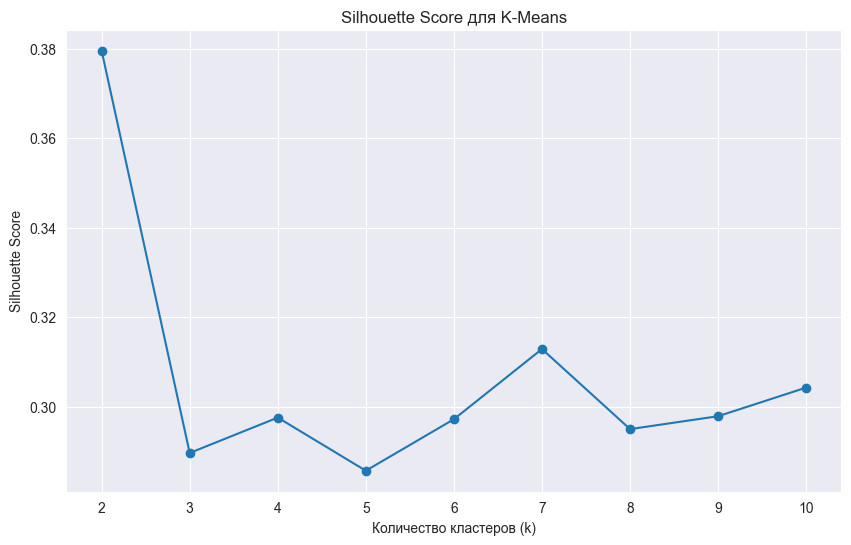

Оптимальное k по Silhouette Score: 2


In [45]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

silhouette_scores = []
K_range_silhouette = range(2, 11) # Silhouette Score не определен для k=1
X_processed = new_scaled_df
for k in K_range_silhouette:
    # Пример для K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(X_processed)
    score_kmeans = silhouette_score(X_processed, cluster_labels_kmeans)
    silhouette_scores.append(score_kmeans)
    print(f"K-Means: k={k}, Silhouette Score = {score_kmeans:.3f}")

    # Пример для GMM (для GMM также применим)
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_processed)
    cluster_labels_gmm = gmm.predict(X_processed)
    score_gmm = silhouette_score(X_processed, cluster_labels_gmm)
    print(f"GMM: k={k}, Silhouette Score = {score_gmm:.3f}")


plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для K-Means')
plt.xticks(K_range_silhouette)
plt.grid(True)
plt.show()

# Оптимальное k - то, которое дает максимальный Silhouette Score
optimal_k_silhouette = K_range_silhouette[np.argmax(silhouette_scores)]
print(f"Оптимальное k по Silhouette Score: {optimal_k_silhouette}")

k=2, Calinski-Harabasz Score = 893.486
k=3, Calinski-Harabasz Score = 745.606
k=4, Calinski-Harabasz Score = 626.376
k=5, Calinski-Harabasz Score = 559.430
k=6, Calinski-Harabasz Score = 545.028
k=7, Calinski-Harabasz Score = 516.448
k=8, Calinski-Harabasz Score = 501.611
k=9, Calinski-Harabasz Score = 489.521
k=10, Calinski-Harabasz Score = 474.321


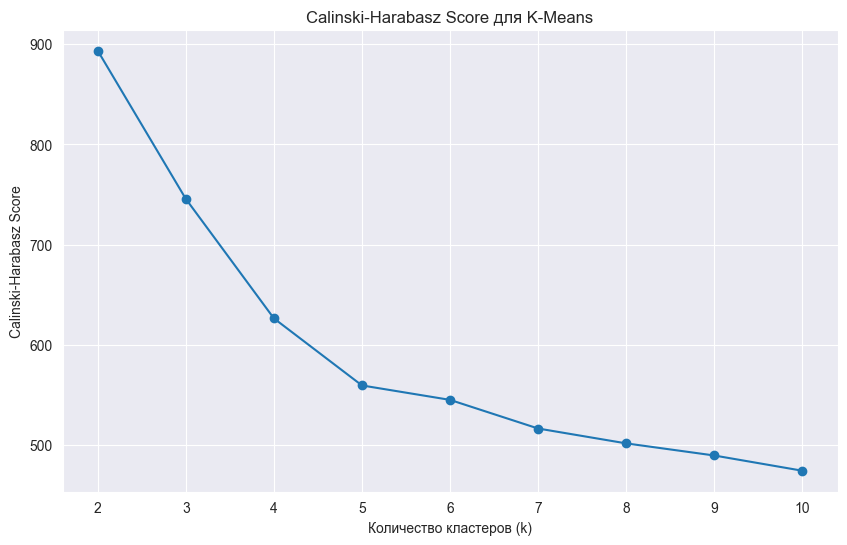

Оптимальное k по Calinski-Harabasz Score: 2


In [46]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = []
K_range_ch = range(2, 11)

for k in K_range_ch:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)
    score = calinski_harabasz_score(X_processed, cluster_labels)
    ch_scores.append(score)
    print(f"k={k}, Calinski-Harabasz Score = {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range_ch, ch_scores, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score для K-Means')
plt.xticks(K_range_ch)
plt.grid(True)
plt.show()

optimal_k_ch = K_range_ch[np.argmax(ch_scores)]
print(f"Оптимальное k по Calinski-Harabasz Score: {optimal_k_ch}")

k=2, Davies-Bouldin Score = 0.977
k=3, Davies-Bouldin Score = 1.152
k=4, Davies-Bouldin Score = 1.166
k=5, Davies-Bouldin Score = 1.243
k=6, Davies-Bouldin Score = 1.163
k=7, Davies-Bouldin Score = 1.104
k=8, Davies-Bouldin Score = 1.050
k=9, Davies-Bouldin Score = 1.046
k=10, Davies-Bouldin Score = 1.065


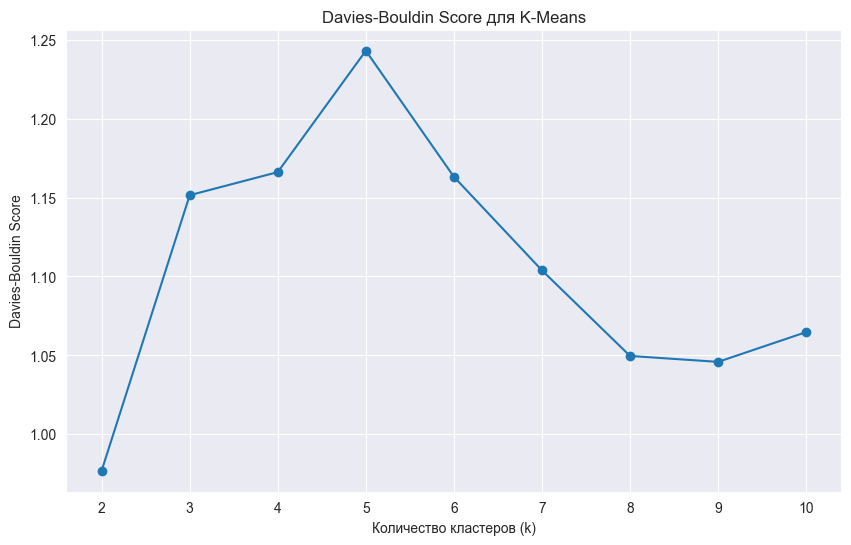

Оптимальное k по Davies-Bouldin Score: 2


In [47]:
from sklearn.metrics import davies_bouldin_score

db_scores = []
K_range_db = range(2, 11)

for k in K_range_db:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)
    score = davies_bouldin_score(X_processed, cluster_labels)
    db_scores.append(score)
    print(f"k={k}, Davies-Bouldin Score = {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range_db, db_scores, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score для K-Means')
plt.xticks(K_range_db)
plt.grid(True)
plt.show()

optimal_k_db = K_range_db[np.argmin(db_scores)]
print(f"Оптимальное k по Davies-Bouldin Score: {optimal_k_db}")

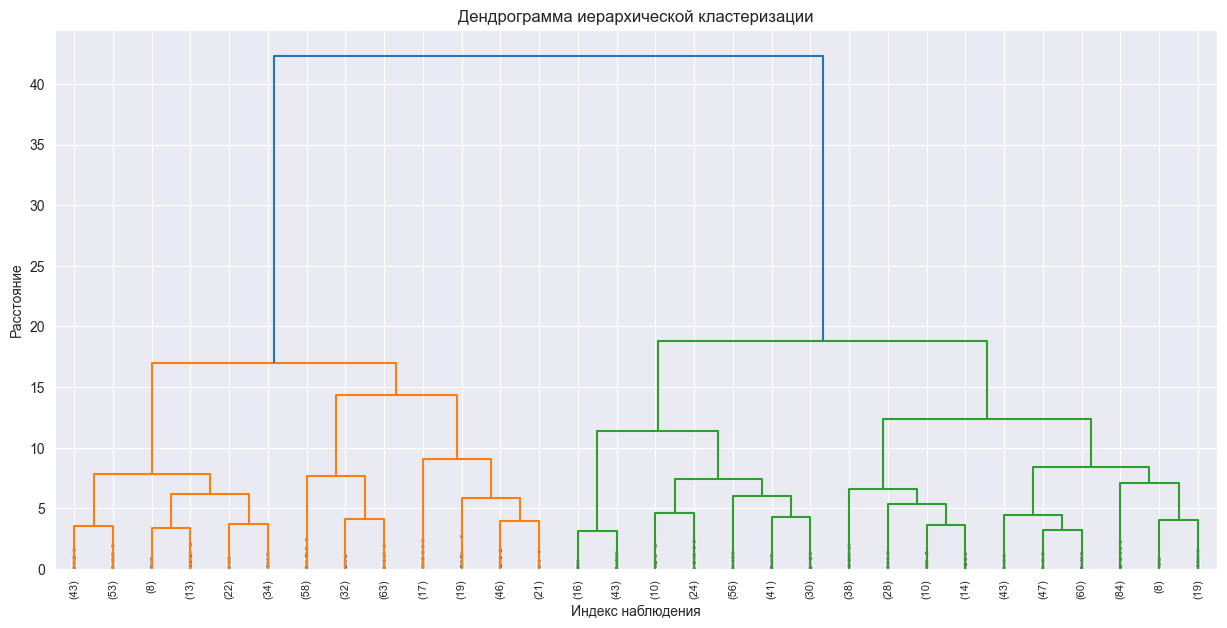


Количество кластеров Agglomerative Clustering: 7
Распределение кластеров: 2    261
1    173
3    161
4    153
0    103
5     90
6     59
Name: count, dtype: int64


In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Применяем иерархическую кластеризацию
# linkage='ward' часто хорошо работает для K-Means-подобных кластеров
Z = linkage(X_processed, method='ward')

plt.figure(figsize=(15, 7))
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Расстояние')
dendrogram(
    Z,
    truncate_mode='lastp',  # Показывает только последние 'p' объединенных кластеров
    p=30,                   # Например, 30 последних объединенных кластеров
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Показывает, сколько оригинальных наблюдений в каждом сжатом кластере
)
plt.show()

# После выбора k из дендрограммы, можно применить AgglomerativeClustering
# Например, если выбрали k=3 из дендрограммы
n_clusters_agg = 7
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_agg, linkage='ward')
clusters_agg = agg_clustering.fit_predict(X_processed)
print(f"\nКоличество кластеров Agglomerative Clustering: {n_clusters_agg}")
print(f"Распределение кластеров: {pd.Series(clusters_agg).value_counts()}")

In [68]:


# Предположим, что мы выбрали K-Means с k=7 как лучший алгоритм и количество кластеров
final_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
final_clusters = final_kmeans.fit_predict(X_processed)

# Добавляем метки кластеров в исходный DataFrame для анализа
df_clustered = new_scaled_df.copy()
df_clustered['cluster'] = final_clusters
print("\nДанные с метками кластеров:")
print(df_clustered.head())


Данные с метками кластеров:
   math score  reading score  writing score  lunch  group E  master's degree  \
0        0.30           0.10       0.235294      1      0.0              0.0   
1        0.15           1.00       0.894118      1      0.0              0.0   
2        1.20           1.25       1.129412      1      0.0              1.0   
3       -0.95          -0.65      -1.176471      0      0.0              0.0   
4        0.50           0.40       0.282353      1      0.0              0.0   

   cluster  
0        1  
1        1  
2        1  
3        0  
4        1  


In [72]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters= 2)
# Добавляем метки кластеров в исходный DataFrame для анализа

final_clusters = clustering.fit_predict(X_processed)
df_clustered = new_scaled_df.copy()
df_clustered['cluster'] = final_clusters
print("\nДанные с метками кластеров:")
print(df_clustered.head())


Данные с метками кластеров:
   math score  reading score  writing score  lunch  group E  master's degree  \
0        0.30           0.10       0.235294      1      0.0              0.0   
1        0.15           1.00       0.894118      1      0.0              0.0   
2        1.20           1.25       1.129412      1      0.0              1.0   
3       -0.95          -0.65      -1.176471      0      0.0              0.0   
4        0.50           0.40       0.282353      1      0.0              0.0   

   cluster  
0        0  
1        0  
2        0  
3        1  
4        0  


In [100]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps= 0.5, min_samples= 9)
# Добавляем метки кластеров в исходный DataFrame для анализа

final_clusters = clustering.fit_predict(X_processed)
df_clustered = new_scaled_df.copy()
df_clustered['cluster'] = final_clusters
print("\nДанные с метками кластеров:")
print(df_clustered.head())


Данные с метками кластеров:
   math score  reading score  writing score  lunch  group E  master's degree  \
0        0.30           0.10       0.235294      1      0.0              0.0   
1        0.15           1.00       0.894118      1      0.0              0.0   
2        1.20           1.25       1.129412      1      0.0              1.0   
3       -0.95          -0.65      -1.176471      0      0.0              0.0   
4        0.50           0.40       0.282353      1      0.0              0.0   

   cluster  
0        0  
1        0  
2       -1  
3        1  
4        0  


In [121]:
from sklearn.cluster import HDBSCAN

clustering = HDBSCAN()
# Добавляем метки кластеров в исходный DataFrame для анализа

final_clusters = clustering.fit_predict(X_processed)
df_clustered = new_scaled_df.copy()
df_clustered['cluster'] = final_clusters
print("\nДанные с метками кластеров:")
print(df_clustered.head())


Данные с метками кластеров:
   math score  reading score  writing score  lunch  group E  master's degree  \
0        0.30           0.10       0.235294      1      0.0              0.0   
1        0.15           1.00       0.894118      1      0.0              0.0   
2        1.20           1.25       1.129412      1      0.0              1.0   
3       -0.95          -0.65      -1.176471      0      0.0              0.0   
4        0.50           0.40       0.282353      1      0.0              0.0   

   cluster  
0        3  
1        3  
2        1  
3        2  
4        3  


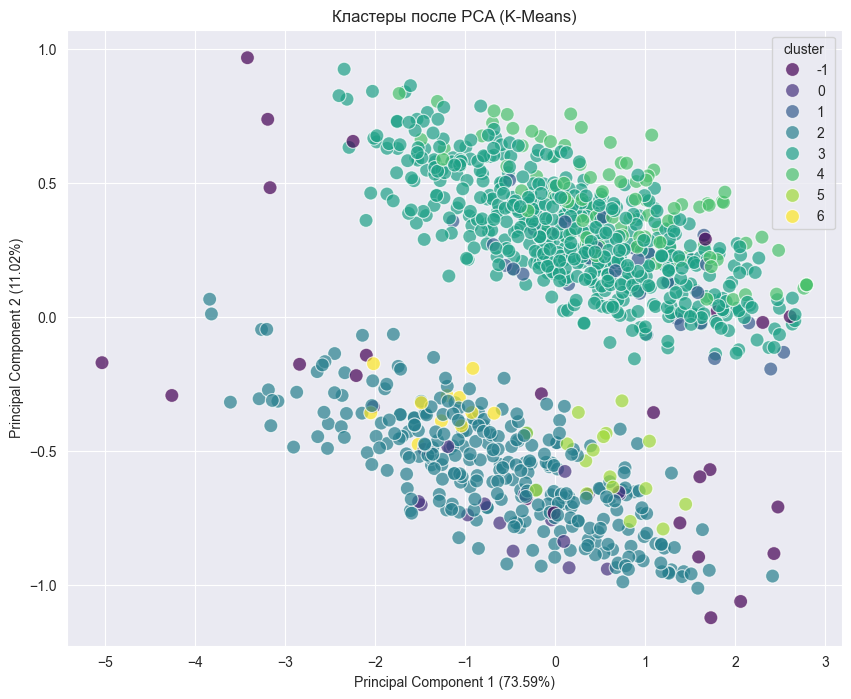

In [122]:
# --- Визуализация с использованием PCA ---
pca = PCA(n_components=2)
components_pca = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(data=components_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = final_clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', legend='full', s=100, alpha=0.7)
plt.title('Кластеры после PCA (K-Means)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.show()

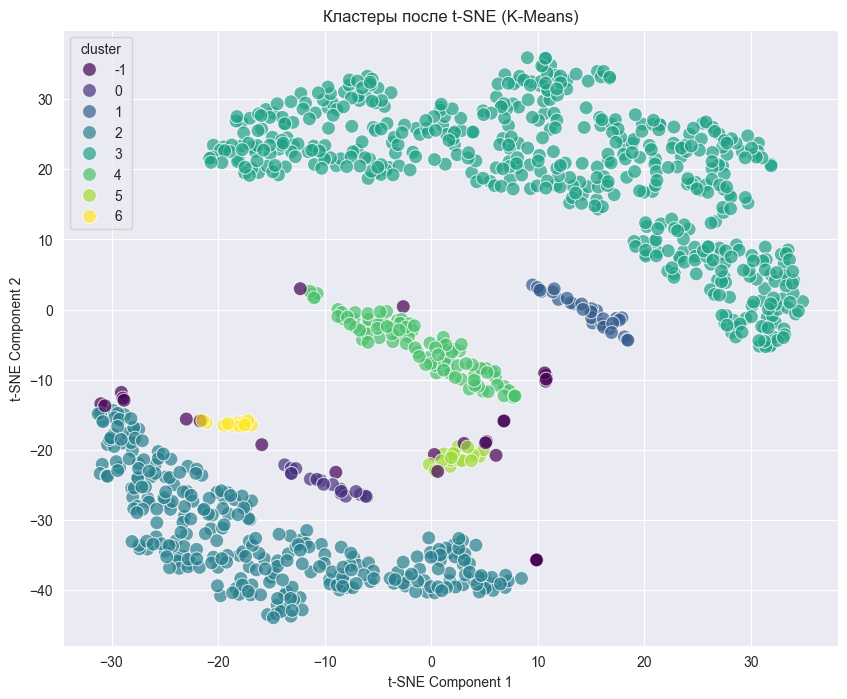

In [123]:
# --- Визуализация с использованием t-SNE ---
# t-SNE может быть медленным для очень больших данных
tsne = TSNE(n_components=2, random_state=42, perplexity=30) # perplexity - важный параметр, регулирует баланс локального/глобального
components_tsne = tsne.fit_transform(X_processed)
tsne_df = pd.DataFrame(data=components_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = final_clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=tsne_df, palette='viridis', legend='full', s=100, alpha=0.7)
plt.title('Кластеры после t-SNE (K-Means)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

F:\Projects\SimpleProj\PandasLearn\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


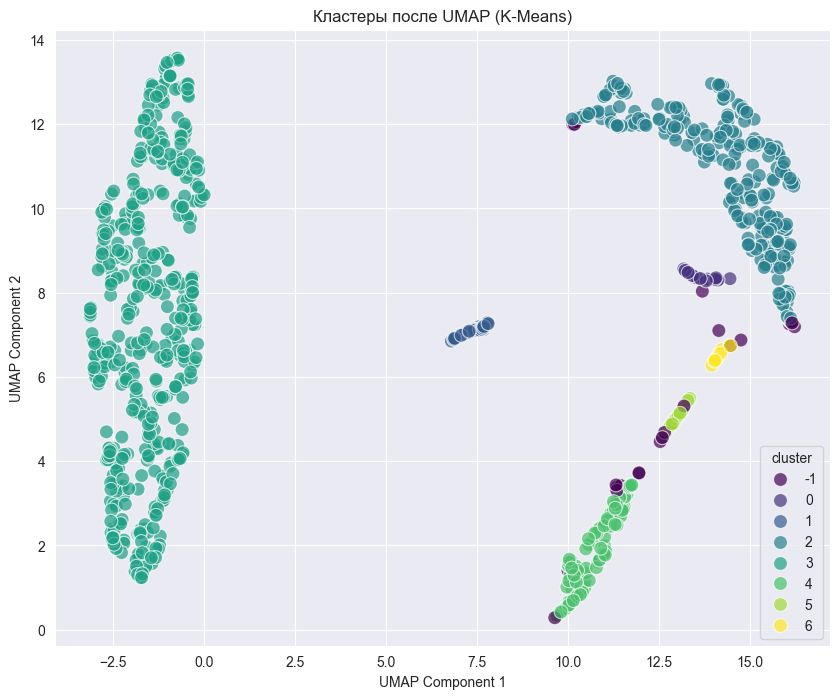

In [124]:
# --- Визуализация с использованием UMAP ---
# Убедитесь, что umap-learn установлен (pip install umap-learn)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_processed)
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['cluster'] = final_clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='viridis', legend='full', s=100, alpha=0.7)
plt.title('Кластеры после UMAP (K-Means)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()